In [1]:
%load_ext memory_profiler

In [50]:
import os
import cv2
import time
import json
import psutil
import numpy as np
from PIL import Image
import albumentations as A
from decimal import Decimal
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from pycocotools.coco import COCO as coco
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
PATH = []
with open('PATH.json','r') as f:
    PATH = json.load(f)
api = coco(annotation_file = os.path.join(PATH['ROOT'], PATH['ValAnn']))
ids = list(api.anns.keys())
anno = {}

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [30]:
def DATA_PATH_LOADING_CROP(PATH, index):
    anno = {}
    anno_dict = api.loadAnns(ids = ids[index])
    if type(anno_dict) == type([]):
        for k in anno_dict[0].keys():
            anno[k] = []
    else:
        for k in anno_dict.keys():
            anno[k] = []
    for i in anno_dict:
        for k ,v in i.items():
            anno[k].append(v)
    img = Image.open(os.path.join(PATH['ROOT'], PATH['ValImg'], api.loadImgs(ids = anno_dict[0]['image_id'])[0]['file_name']))
    standard_x = 224
    standard_y = 224
    bbox = []
    bbox.append(int(Decimal(anno['bbox'][0][0]).quantize(Decimal("1."), rounding = "ROUND_HALF_UP")))
    bbox.append(int(Decimal(anno['bbox'][0][1]).quantize(Decimal("1."), rounding = "ROUND_HALF_UP")))
    bbox.append(int(Decimal(anno['bbox'][0][0] + anno['bbox'][0][2]).quantize(Decimal("1."), rounding = "ROUND_HALF_UP")))
    bbox.append(int(Decimal(anno['bbox'][0][1] + anno['bbox'][0][3]).quantize(Decimal("1."), rounding = "ROUND_HALF_UP")))
    c_img = img.crop((bbox[0], bbox[1], bbox[2], bbox[3]))
    ratio_x = standard_x / c_img.size[0]
    ratio_y = standard_y / c_img.size[1]
    c_img = c_img.resize((standard_x,standard_y), Image.BILINEAR)
    kypt = []
    kweight = []
    for i in range(int(len(anno['keypoints'][0])/3)):
        tmp = []
        if anno['keypoints'][0][i*3] - bbox[0] > 0 and anno['keypoints'][0][i*3+1] - bbox[1] > 0:
            tmp.append(float(Decimal((anno['keypoints'][0][i*3] - bbox[0]) * ratio_x).quantize(Decimal("0.1"), rounding = "ROUND_HALF_UP")))
            tmp.append(float(Decimal((anno['keypoints'][0][i*3+1] - bbox[1]) * ratio_y).quantize(Decimal("0.1"), rounding = "ROUND_HALF_UP")))
            kweight.append(anno['keypoints'][0][i*3+2])
        else:
            tmp.append(0)
            tmp.append(0)
            kweight.append(0)
        kypt.append(tmp)
    #img = np.array(img)
    c_anno = {'keypoints':kypt, 'weights':kweight}
    return img, anno, c_img, c_anno

In [22]:
def Augmentation(img, anno):
    img = np.array(img)
    transform = A.Compose([A.RandomRotate90(p = 1),
                           A.RandomBrightnessContrast(p = 1)], 
                          keypoint_params = A.KeypointParams(format = 'xy'))
    transformed = transform(image = img, keypoints = anno['keypoints'])
    img = transformed['image']
    anno['keypoints'] = transformed['keypoints']
    return img, anno

In [23]:
def PLOT(img, anno, bbox_dis = False):
    fig, ax = plt.subplots()
    cmp = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff', '#ff8000', '#80ff00']
    skeleton = [[15,13],[13,11],[16,14],[14,12],[11,12],[5,11],[6,12],[5,6],[5,7],[6,8],[7,9],[8,10],[1,2],[0,1],[0,2],[1,3],[2,4],[3,5],[4,6]]
    ax.imshow(img)
    kypt = anno['keypoints']
    anno_x = []
    anno_y = []
    anno_w = []
    if len(kypt[0]) < 3:
        for k in kypt:
            anno_x.append(k[0])
            anno_y.append(k[1])    
        anno_w = anno['weights']
    else:
        for k in range(int(len(kypt[0])/3)):
            anno_x.append(kypt[0][k*3])
            anno_y.append(kypt[0][k*3+1])
            anno_w.append(kypt[0][k*3+2])
    ax.scatter(anno_x, anno_y, marker = '.', color = cmp[1])
    for i in skeleton:
        #if anno_x[i[0]] != 0 and anno_x[i[1]] != 0 and anno_y[i[0]] != 0 and anno_y[i[1]] != 0:
        if anno_w[i[0]] != 0 and anno_w[i[1]] != 0:
            x = []
            y = []
            x.append(anno_x[i[0]])
            x.append(anno_x[i[1]])
            y.append(anno_y[i[0]])
            y.append(anno_y[i[1]])
            ax.plot(x, y , linestyle = '-', color = cmp[1])
    if bbox_dis:
        bbox = []
        codes = []
        vertices = []
        codes = [Path.MOVETO] + [Path.LINETO]*3 + [Path.CLOSEPOLY]
        bbox.append(anno['bbox'][0][0])
        bbox.append(anno['bbox'][0][1])
        bbox.append(anno['bbox'][0][0] + anno['bbox'][0][2])
        bbox.append(anno['bbox'][0][1] + anno['bbox'][0][3])
        vertices = [(bbox[0], bbox[1]), (bbox[0], bbox[3]), (bbox[2], bbox[3]), (bbox[2], bbox[1]), (0, 0)]
        path = Path(vertices, codes)
        pathpatch = PathPatch(path, facecolor ='none', edgecolor = cmp[1])
        ax.add_patch(pathpatch)
    plt.show()
    #fig.savefig('./output.jpg')
    return

In [57]:
def gaussian_heatmap(anno, shape, sigma=8):
    kypt = anno['keypoints']
    heatmap = []
    for i in range(len(kypt)):
        if anno['weights'][i] != 0: 
            coords = kypt[i]
            x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
            dists = np.sqrt((x[:, :, np.newaxis] - coords[0])**2 +
                            (y[:, :, np.newaxis] - coords[1])**2)
            gaussians = np.exp(-dists**2 / (2 * sigma**2))
            tmp = np.sum(gaussians, axis=2)
            tmp /= np.max(tmp)
            heatmap.append(tmp)
        else:
            heatmap.append(np.zeros(shape))
    heatmap = np.array(heatmap)
    return heatmap

In [58]:
def PLOT_HEATMAP(heatmap):
    label = ["nose","left_eye","right_eye","left_ear","right_ear","left_shoulder","right_shoulder","left_elbow","right_elbow","left_wrist","right_wrist","left_hip","right_hip","left_knee","right_knee","left_ankle","right_ankle"]
    for i in range(17):
        plt.subplot(5, 4, i+1)
        plt.imshow(heatmap[i])
        plt.title(label[i])
    plt.tight_layout()
    plt.show()
    return

peak memory: 268.13 MiB, increment: 0.00 MiB
CPU times: user 111 ms, sys: 37.4 ms, total: 149 ms
Wall time: 262 ms


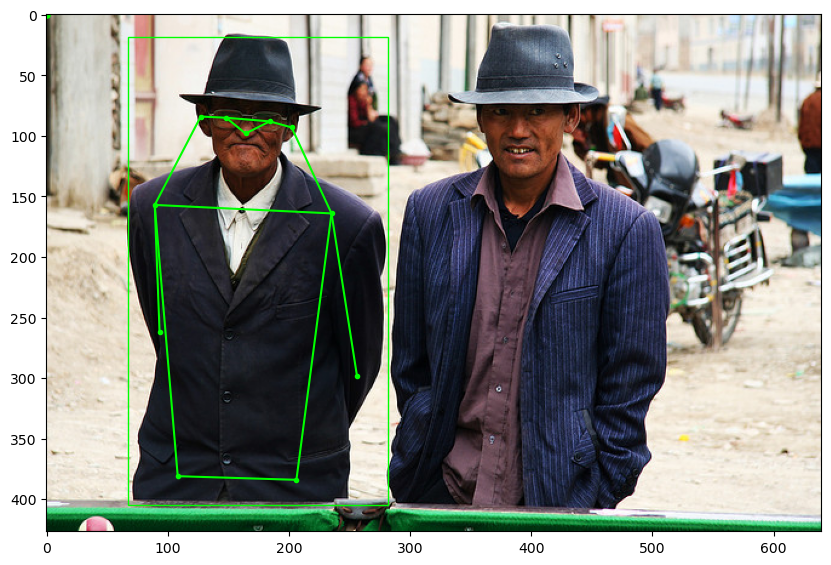

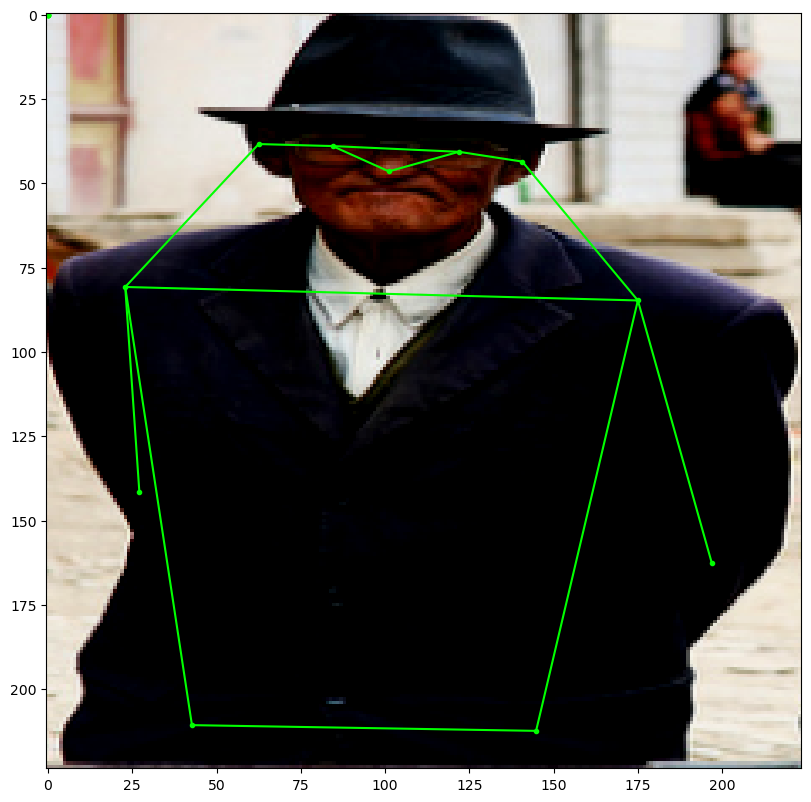

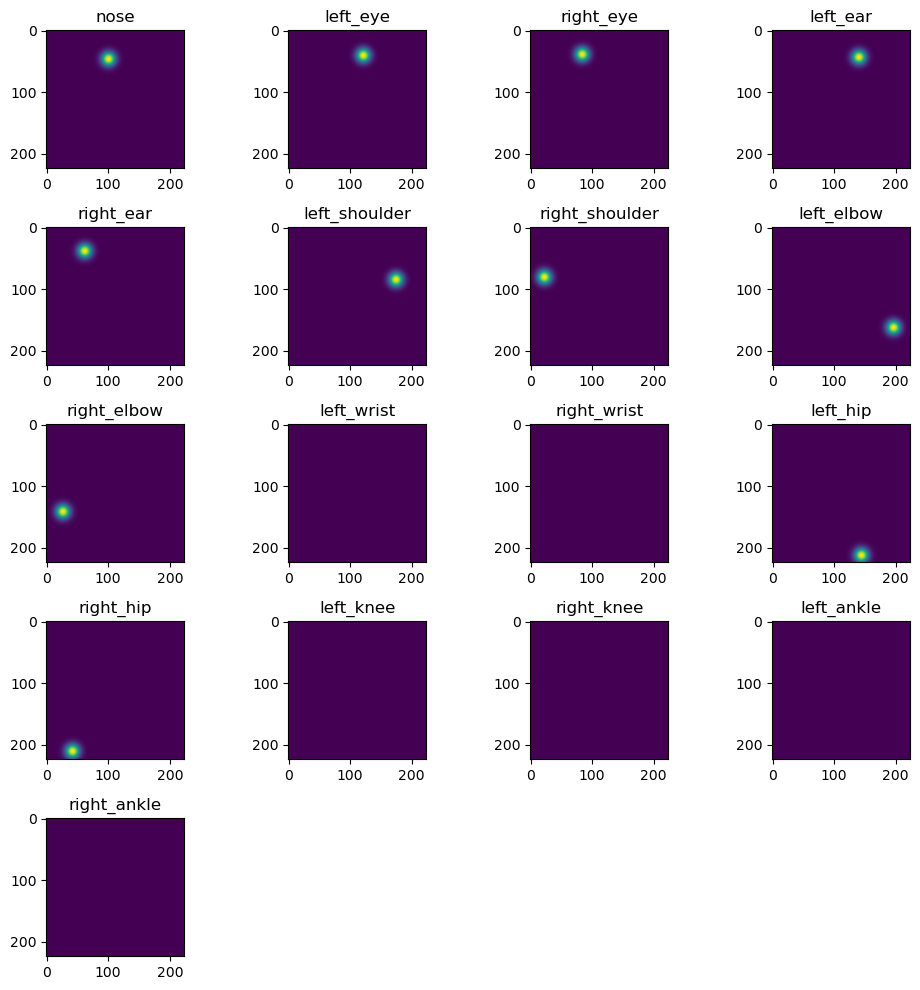

In [59]:
def main():
    anno = {}
    %time %memit
    img, anno, c_img, c_anno = DATA_PATH_LOADING_CROP(PATH, 26)
    c_img, c_anno = Augmentation(c_img, c_anno)
    heatmap = gaussian_heatmap(c_anno, (224, 224))
    PLOT(img, anno, bbox_dis = True)
    PLOT(c_img, c_anno, bbox_dis = False)
    PLOT_HEATMAP(heatmap)
anno = main()

In [ ]:
print(anno)

None
